In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
# Load data
data = pd.read_csv('stock_data.csv', parse_dates=True, index_col='Date')
data = data[['Close']]  # Assuming you are only using 'Close' prices

# Fill any NaNs
data['Close'].fillna(method='ffill', inplace=True)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a function to create sequences and labels
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split data into train and test
look_back = 60
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size - look_back:,:]

# Create datasets
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

<ipython-input-2-f63ae0b7f5dd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'].fillna(method='ffill', inplace=True)


In [3]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
36/36 [==============================] - 8s 80ms/step - loss: 0.0190 - val_loss: 0.0036
Epoch 2/20
36/36 [==============================] - 2s 53ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/20
36/36 [==============================] - 2s 51ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/20
36/36 [==============================] - 2s 51ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 5/20
36/36 [==============================] - 2s 62ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/20
36/36 [==============================] - 3s 71ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/20
36/36 [==============================] - 2s 50ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/20
36/36 [==============================] - 3s 88ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/20
36/36 [==============================] - 4s 98ms/step - loss: 9.8505e-04 - val_loss: 0.0012
Epoch 10/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch

In [4]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
actual_y_train = scaler.inverse_transform([y_train])
actual_y_test = scaler.inverse_transform([y_test])

# Calculate and print RMSE
train_score = np.sqrt(mean_squared_error(actual_y_train[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(actual_y_test[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

10/10 [==============================] - 0s 15ms/step
Train Score: 4.02 RMSE
Test Score: 4.66 RMSE


Total samples: 1491
Train size: 1192
Test size: 359
Length of train predictions: 1131
Length of test predictions: 298
Start index for test predictions: 1193


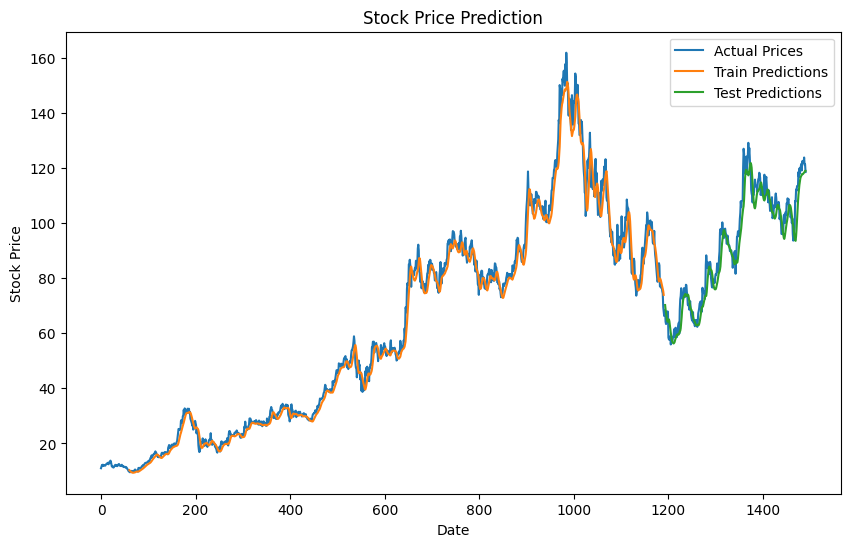

In [8]:
# Calculate lengths to ensure they are accurate
print(f"Total samples: {total_samples}")
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(f"Length of train predictions: {len(train_predict)}")
print(f"Length of test predictions: {len(test_predict)}")

# Adjusted plotting logic
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Since test predictions start later, calculate the starting point
start_index = total_samples - len(test_predict)
print(f"Start index for test predictions: {start_index}")

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[start_index:start_index + len(test_predict), :] = test_predict

# Plotting
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Prices')
plt.plot(train_plot, label='Train Predictions')
plt.plot(test_plot, label='Test Predictions')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

1/1 [==============================] - 0s 84ms/step


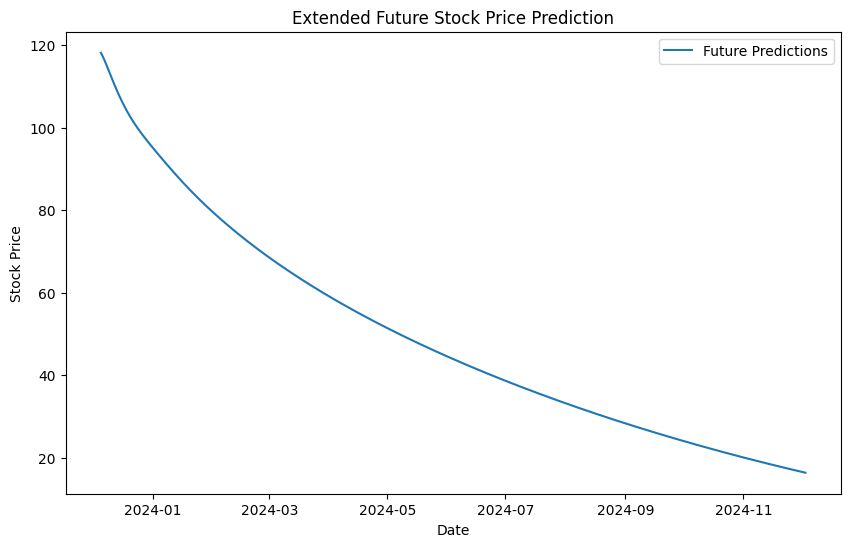

In [14]:
import numpy as np

data = pd.read_csv('stock_data.csv', parse_dates=['Date'])

# Get the last date from the dataset
last_date = data['Date'].iloc[-1]

# Number of days to predict into the future
future_days = 365

# Last `look_back` days from the dataset to start prediction
last_look_back = scaled_data[-look_back:]

# List to hold the predictions
future_predictions = []

# Start with the last look_back data
new_input = last_look_back.reshape(1, look_back, 1)

# Predict future days
for _ in range(future_days):
    # Get the next day's prediction
    future_pred = model.predict(new_input)
    future_predictions.append(future_pred[0, 0])

    # Update the new_input to include the prediction and drop the oldest data point
    future_pred_reshaped = future_pred.reshape(1, 1, 1)  # Reshape to (1, 1, 1)
    new_input = np.append(new_input[:, 1:, :], future_pred_reshaped, axis=1)

# Inverse transform the predictions to get them back to the original scale
future_predictions_scaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates (assuming the last date in your dataset is known)
# last_date = pd.to_datetime('your_dataset_last_date')
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(future_dates, future_predictions_scaled, label='Future Predictions')
plt.legend()
plt.title("Extended Future Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()



In [16]:
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions_scaled.flatten()})
future_df

,Date,Predicted Price
0,2023-12-05,118.142700
1,2023-12-06,117.227867
2,2023-12-07,116.174416
3,2023-12-08,115.044464
4,2023-12-09,113.878525
...,...,...
360,2024-11-29,16.806585
361,2024-11-30,16.696123
362,2024-12-01,16.586048
363,2024-12-02,16.476362
